<h3><b>VIDEO RATINGS ANALYSIS</b></h3>
<p>Takes the video ratings scores for the three outcomes (fear, disgust and points) at two timepoints (for fear and disgust:only one rating for points)</p>
<p>Carries out the checks using mixed effects models, as specified in the analysis plan (as well as detailing what is expected from these checks)</p>
<br>
<p>NB this current version is run on fake data - randomly generated (so won't see any expected effects)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
from functools import reduce
import statistics
import scipy.stats
import seaborn as sns
import math
import os
import json
import ast
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy import std, mean, sqrt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.copy_on_write = True

In [33]:
##remove later --> just getting rid of convergence warnings for dummy data
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [34]:
chosen_stim_df = pd.read_csv("csvs/chosen_stim_dummy.csv")
chosen_stim_df.drop('Unnamed: 0', axis="columns", inplace=True)

In [35]:
#create long form df which allows for this
long_chosen_stim_df=pd.DataFrame()
for i in chosen_stim_df.index:
    row=chosen_stim_df.loc[i]
    #timepoint=['unpleasan']
    timepoint_1=pd.DataFrame({
    'participant_no': [row.participant_no],
    'age': [row.prolific_age],
    'sex': [row. prolific_sex],
    'Vid': [str(row['Vid'])],
    'trial_type': [row.trial_type],
    'Valence': [row.unpleasant_1],
    'Arousal': [row.arousing_1],
    'Fear': [row.frightening_1],
    'Disgust': [row.disgusting_1],
    'Timepoint': 1.0
    })
    timepoint_2=pd.DataFrame({
        'participant_no': [row.participant_no],
        'age': [row.prolific_age],
        'sex': [row. prolific_sex],
        'Vid': [str(row['Vid'])],
        'trial_type': [row.trial_type],
        'Valence': [row.unpleasant_2],
        'Arousal': [row.arousing_2],
        'Fear': [row.frightening_2],
        'Disgust': [row.disgusting_2],
        'Timepoint': 2.0
    })
    long_chosen_stim_df_row=pd.concat([timepoint_1, timepoint_2])
    long_chosen_stim_df=pd.concat([long_chosen_stim_df_row, long_chosen_stim_df])
    long_chosen_stim_df=long_chosen_stim_df[long_chosen_stim_df.trial_type!="points"]

<b>1. ANALYSING THE CHOSEN STIMULI (Fear and disgust)</b>
<p> Doing this using 4 mixed effects models - testing effect of timepoint and stimulus type on ratings </p>
<p>List of models to run:
<li> A) 'Valence ~ trial_type*Timepoint'
<li> B) 'Arousal ~ trial_type*Timepoint'
<li> C) 'Disgust ~ trial_type*Timepoint'
<li> D) 'Fear ~ trial_type*Timepoint'

Model A: Valence ~ trial_type*Timepoint

In [36]:
##Test the fit of different variations of model A
data=long_chosen_stim_df.reset_index()
data.replace(['disgust', 'fear'], [1.0,2.0], inplace=True)

formula = 'Valence ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)


   basic_model  vid_randint   randslope  vid_randint_randslope
0   286.910737   287.618746  294.081783             298.276674


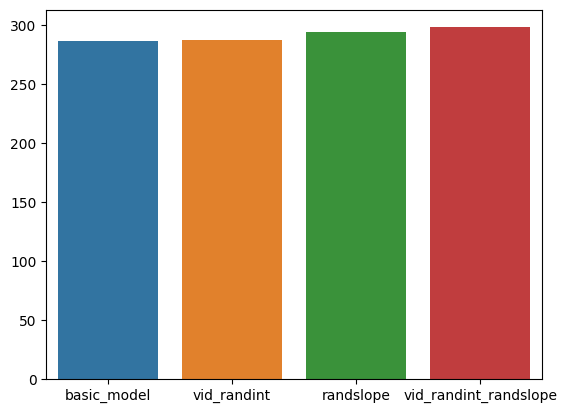

In [37]:
#test which random effects to include
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##in this case, basic model is the best

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0    286.910737       290.2101     289.211994         292.959289


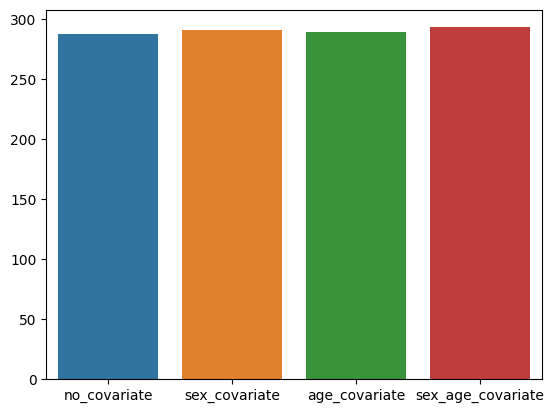

In [38]:
##test which covariates to add -- Using the random effects which were best above
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic)
print(bic) ##in this case, nocovariate is the best

In [39]:
#Hypothesis test using this model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   Valence  
No. Observations:     56        Method:               ML       
No. Groups:           14        Scale:                5.8414   
Min. group size:      4         Log-Likelihood:       -131.3793
Max. group size:      4         Converged:            Yes      
Mean group size:      4.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             6.643    3.237  2.052 0.040  0.299 12.987
trial_type           -0.714    2.043 -0.350 0.727 -4.718  3.289
Timepoint            -1.714    2.043 -0.839 0.401 -5.718  2.289
trial_type:Timepoint  0.500    1.292  0.387 0.699 -2.032  3.032
Group Var             0.627    0.377                           
===============================================================

"""

In [40]:
##and also the model with no covariates (to see how results change) --> only necessary if winning model isn't including covariates
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   Valence  
No. Observations:     56        Method:               ML       
No. Groups:           14        Scale:                5.8414   
Min. group size:      4         Log-Likelihood:       -131.3793
Max. group size:      4         Converged:            Yes      
Mean group size:      4.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             6.643    3.237  2.052 0.040  0.299 12.987
trial_type           -0.714    2.043 -0.350 0.727 -4.718  3.289
Timepoint            -1.714    2.043 -0.839 0.401 -5.718  2.289
trial_type:Timepoint  0.500    1.292  0.387 0.699 -2.032  3.032
Group Var             0.627    0.377                           
===============================================================

"""

Now do the same for model B: Arousal ~ trial_type*Timepoint

In [41]:
##mixed effects model Arousal (model B)
formula = 'Arousal ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model  vid_randint   randslope  vid_randint_randslope
0    275.24956   274.846642  280.088176             285.526631


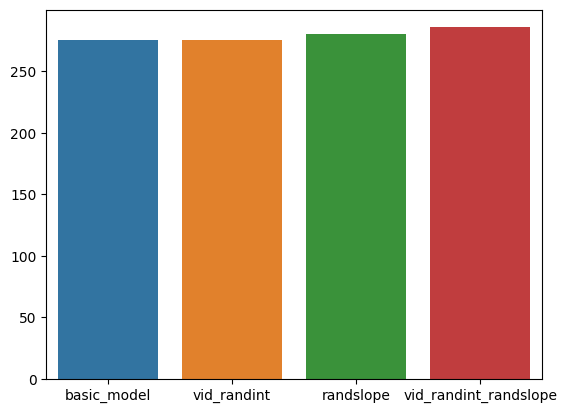

In [42]:
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##in this case, vidrandint is best

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0    274.846642     278.711348     278.556387         282.230254


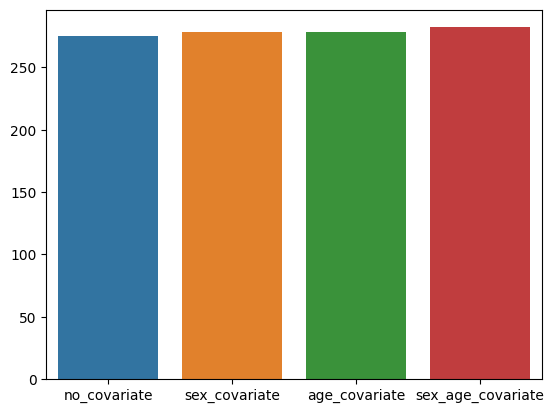

In [43]:
##test which covariates to add -- Using the random effects which were best above (vid_rantint)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic)
print(bic) ##in this case, nocovariate is the best

In [44]:
#Hypothesis test using this model (and with no_covariates anyways if this isn't the best model)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   Arousal  
No. Observations:     56        Method:               ML       
No. Groups:           14        Scale:                4.5662   
Min. group size:      4         Log-Likelihood:       -125.3473
Max. group size:      4         Converged:            Yes      
Mean group size:      4.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.071    2.894  1.407 0.159 -1.601  9.744
trial_type           -0.071    1.830 -0.039 0.969 -3.659  3.516
Timepoint            -0.286    1.806 -0.158 0.874 -3.825  3.254
trial_type:Timepoint  0.143    1.142  0.125 0.900 -2.096  2.382
Vid Var               0.620    0.514                           
===============================================================

"""

Model 3: Fear ~ trial_type*Timepoint

In [45]:
##mixed effects model Fear (model C)
formula = 'Fear ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model  vid_randint   randslope  vid_randint_randslope
0   288.885324   288.885324  295.552658             300.538496


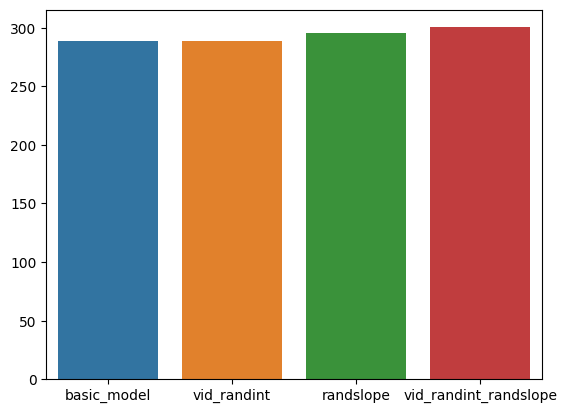

In [46]:
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##in this case, basic model and vidrandint are the same
    #go for most basic model in this case

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0    288.885324     292.734059     292.043411         295.540576


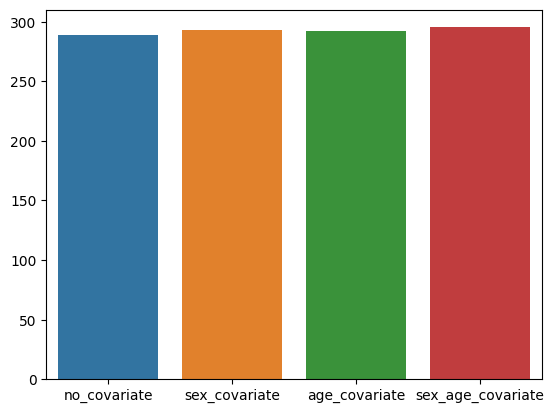

In [47]:
##test which covariates to add -- Using the random effects which were best above (vid_rantint)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic)
print(bic) ##in this case, nocovariate is the best

In [48]:
#Hypothesis test using this model (and with no_covariates anyways if this isn't the best model)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   Fear     
No. Observations:     56        Method:               ML       
No. Groups:           14        Scale:                6.6161   
Min. group size:      4         Log-Likelihood:       -132.3666
Max. group size:      4         Converged:            Yes      
Mean group size:      4.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             8.071    3.437  2.348 0.019  1.335 14.808
trial_type           -2.571    2.174 -1.183 0.237 -6.832  1.689
Timepoint            -1.286    2.174 -0.591 0.554 -5.546  2.975
trial_type:Timepoint  0.929    1.375  0.675 0.499 -1.766  3.623
Group Var             0.000                                    
===============================================================

"""

Finally - model D: Disgust ~ trial_type*Timepoint

In [49]:
##mixed effects model Disgust (model D)
formula = 'Disgust ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model  vid_randint   randslope  vid_randint_randslope
0   265.919597   265.919567  273.630459             278.535672


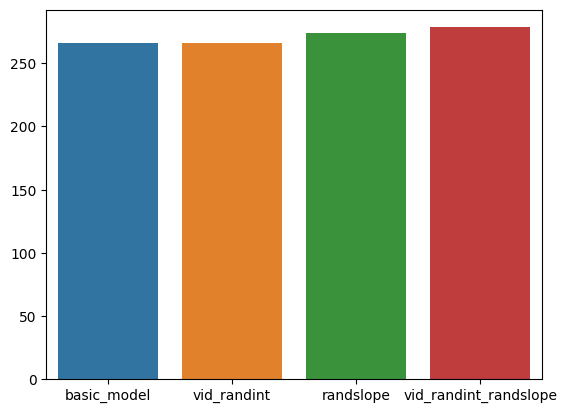

In [50]:
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##vidrandint

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0    265.919567     269.868603     269.664086         273.486734


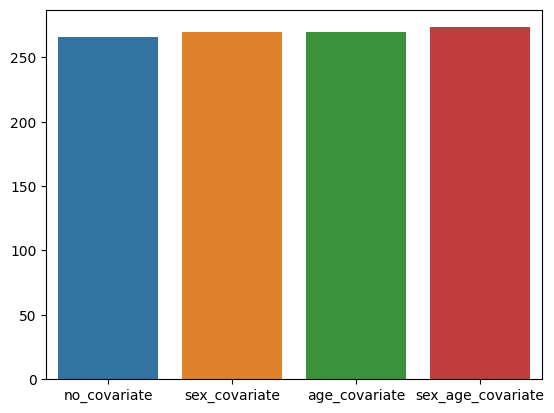

In [51]:
##test which covariates to add -- Using the random effects which were best above (vid_rantint)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic)
print(bic) ##in this case, nocovariate is the best

In [52]:
#Hypothesis test using this model (and with no_covariates anyways if this isn't the best model)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   Disgust  
No. Observations:     56        Method:               ML       
No. Groups:           14        Scale:                4.3903   
Min. group size:      4         Log-Likelihood:       -120.8837
Max. group size:      4         Converged:            Yes      
Mean group size:      4.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -1.214    2.800 -0.434 0.665 -6.702  4.274
trial_type            4.214    1.771  2.380 0.017  0.743  7.685
Timepoint             2.714    1.771  1.533 0.125 -0.757  6.185
trial_type:Timepoint -2.286    1.120 -2.041 0.041 -4.481 -0.091
Vid Var               0.000    0.489                           
===============================================================

"""

<b>Interpretation of these models:</b>
<li>Expect matched valence and arousal across fear and disgusting video types (no effect of video type in models A+B)
<li>Expect differences in fear and disgust ratings across video types (effect of video type in models C+D)
<li>Expect some habituation of ratings (an effect of time) (effect of time in models A,B,C, or D)
<li> Might be different habituation between fear and disgust (fear*time interaction in models A,B,C,or D)
<br>
<p>Followup analyses in main hypothesis testing required:(models 1-6 in task_model_free_analysis) </p>
<li>If there is a difference in valence and arousal across fear and disgusting videos: add this difference as a covariate (fear(T1)-disgust(T1))
<li>If there is a difference in habituation between fear and disgusting videos: add this difference in habituation as a covariate (Fear(T1-T2) - Disgust(T1-T2))

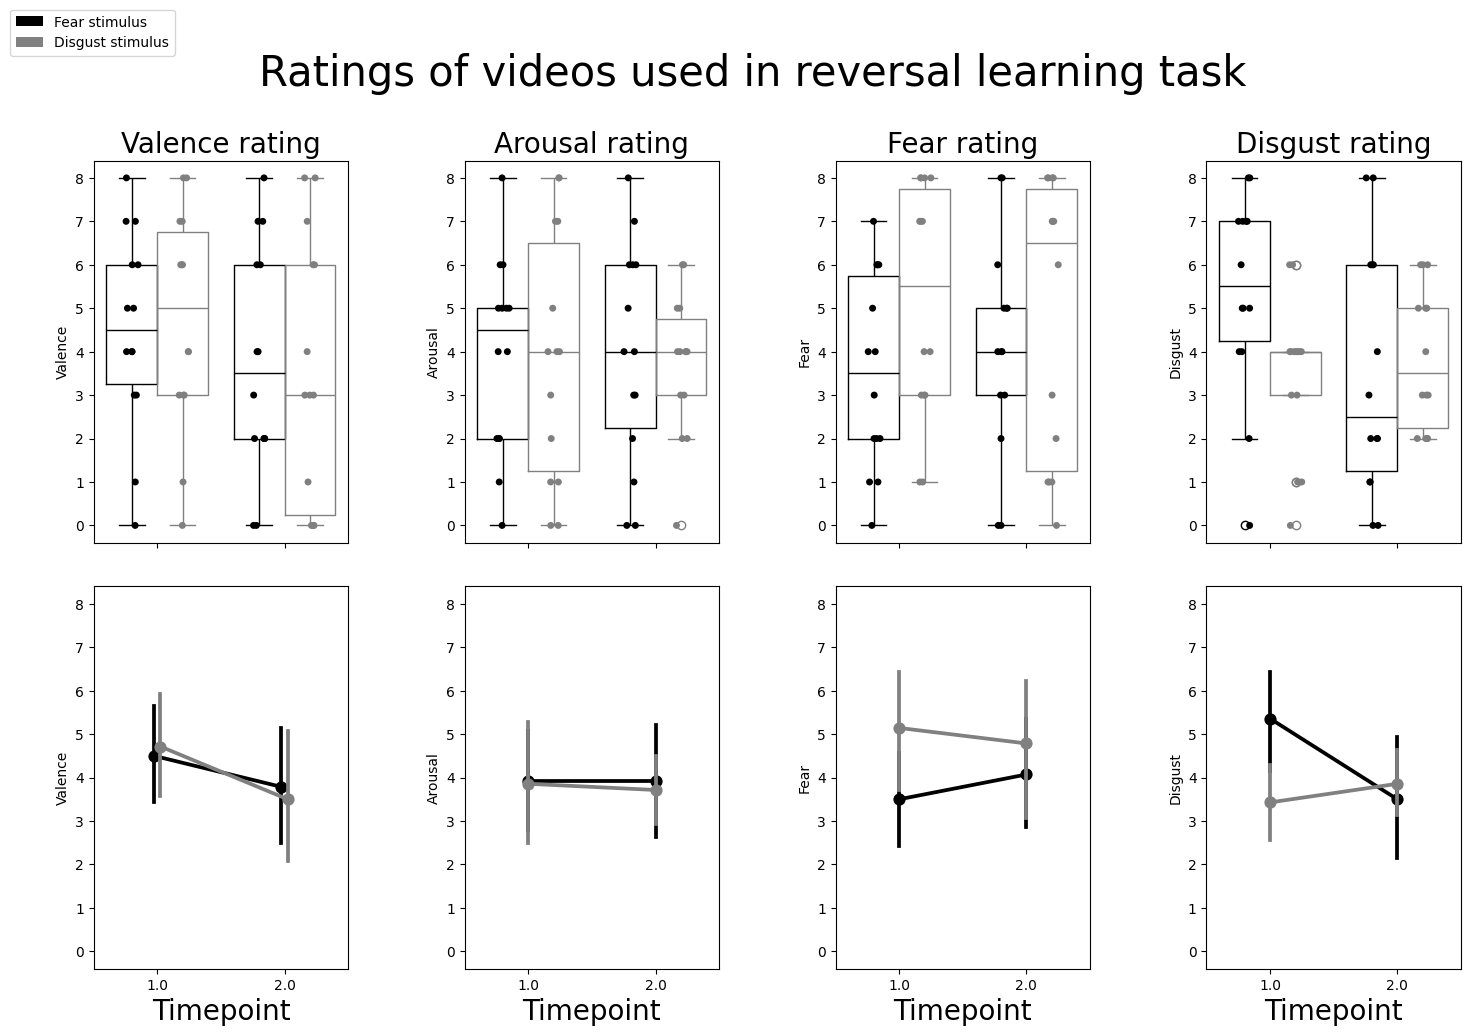

In [53]:
#example plot for this data
fig, axes = plt.subplots(2,4, sharex='col', sharey='col')
title="Ratings of videos used in reversal learning task"
plt.suptitle(title, fontsize=30)
fig.tight_layout(pad=0.5)
fig.set_size_inches(15, 10)

palette = {'fear': '0',
            'disgust': '0.5'}
sns.stripplot(data=long_chosen_stim_df, ax=axes[0,0], x='Timepoint', y='Valence', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,0], x='Timepoint', y='Valence', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,0].get_legend().set_visible(False)
axes[0,0].set_title("Valence rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,0], x='Timepoint', y='Valence', hue='trial_type', dodge=True, palette=palette)
axes[1,0].get_legend().set_visible(False)
axes[1,0].xaxis.get_label().set_fontsize(20)

sns.stripplot(data=long_chosen_stim_df, ax=axes[0,1], x='Timepoint', y='Arousal', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,1], x='Timepoint', y='Arousal', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,1].get_legend().set_visible(False)
axes[0,1].set_title("Arousal rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,1], x='Timepoint', y='Arousal', hue='trial_type', dodge=False, palette=palette)
axes[1,1].get_legend().set_visible(False)
axes[1,1].xaxis.get_label().set_fontsize(20)

sns.stripplot(data=long_chosen_stim_df, ax=axes[0,2], x='Timepoint', y='Fear', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,2], x='Timepoint', y='Fear', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,2].get_legend().set_visible(False)
axes[0,2].set_title("Fear rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,2], x='Timepoint', y='Fear', hue='trial_type', dodge=False, palette=palette)
axes[1,2].get_legend().set_visible(False)
axes[1,2].xaxis.get_label().set_fontsize(20)

sns.stripplot(data=long_chosen_stim_df, ax=axes[0,3], x='Timepoint', y='Disgust', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,3], x='Timepoint', y='Disgust', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,3].get_legend().set_visible(False)
axes[0,3].set_title("Disgust rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,3], x='Timepoint', y='Disgust', hue='trial_type', dodge=False, palette=palette)
axes[1,3].get_legend().set_visible(False)
axes[1,3].xaxis.get_label().set_fontsize(20)

plt.figlegend(loc='center left', bbox_to_anchor=(0,1),  handles=[mpatches.Patch(facecolor='0'), mpatches.Patch(facecolor='0.5')], labels=['Fear stimulus', 'Disgust stimulus'])
plt.show()

<b>2. CHECK POINTS RATINGS</b>
<p>Aim: check whether points block differs from other blocks in terms of ratings (at T1) - a sanity check</p>
<p>List of models to run: </p>
<li> E) 'disgusting_1 ~ trial_type'
<li> F) 'frightening_1 ~ trial_type'
<li> G) 'unpleasant_1 ~ trial_type'
<li> H) 'arousing_1 ~ trial_type'

Model E: 'disgusting_1 ~ trial_type'

In [64]:
#Model E
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1', 'Vid', 'prolific_age', 'prolific_sex']]
data.replace(['disgust', 'fear', 'points'], [1.0,2.0, 3.0], inplace=True)

formula = 'unpleasant_1 ~ trial_type'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model  vid_randint   randslope  vid_randint_randslope
0   260.154603   139.686418  264.878719             301.055837


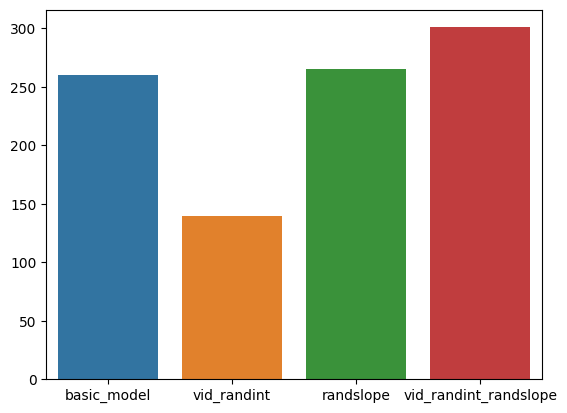

In [65]:
#test random effects
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##in this case, vidrandint is best

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0    139.686418     138.618563     140.871535          140.82713


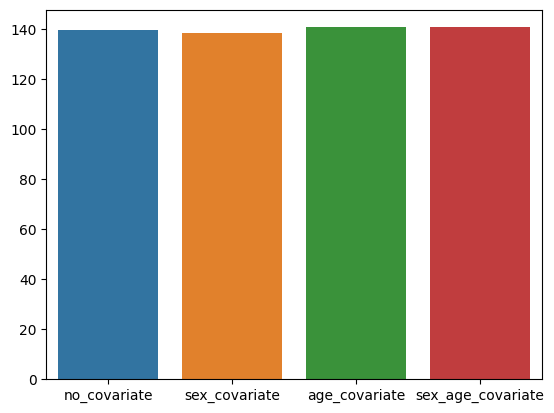

In [67]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic)
print(bic) ##in this case, just the sex covariate is best

In [68]:
#Hypothesis test using this model
sex_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:             MixedLM  Dependent Variable:  unpleasant_1
No. Observations:  28       Method:              ML          
No. Groups:        14       Scale:               2.6024      
Min. group size:   2        Log-Likelihood:      -60.9788    
Max. group size:   2        Converged:           Yes         
Mean group size:   2.0                                       
-------------------------------------------------------------
                     Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept            2.992    1.665 1.797 0.072 -0.272  6.256
prolific_sex[T.Male] 2.515    1.225 2.053 0.040  0.114  4.917
trial_type           0.008    0.727 0.012 0.991 -1.417  1.434
Vid Var              0.000    0.000                          
=============================================================

"""

In [69]:
##and the no covariates version
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: unpleasant_1
No. Observations: 28      Method:             ML          
No. Groups:       14      Scale:              4.7761      
Min. group size:  2       Log-Likelihood:     -63.1788    
Max. group size:  2       Converged:          Yes         
Mean group size:  2.0                                     
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    4.908     1.385   3.544  0.000   2.194   7.623
trial_type  -0.211     0.849  -0.248  0.804  -1.874   1.453
Vid Var      0.000     0.000                               
==========================================================

"""

Model F: arousing_1 ~ trial_type

In [70]:
#Model F
formula = 'arousing_1 ~ trial_type'
model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model  vid_randint   randslope  vid_randint_randslope
0   274.640434   143.780209  276.513816             331.059588


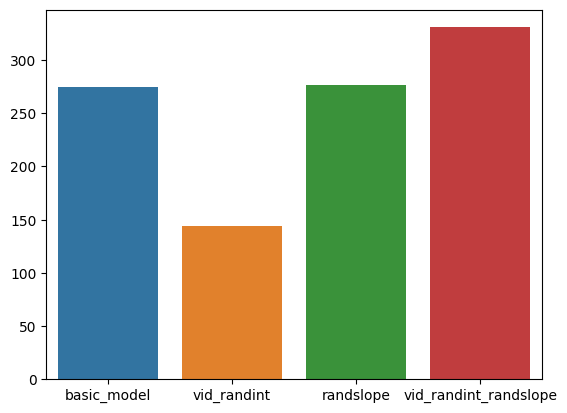

In [71]:
#test random effects
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##in this case, vidrandint is best

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0    143.780209     144.850032     145.768685         145.929952


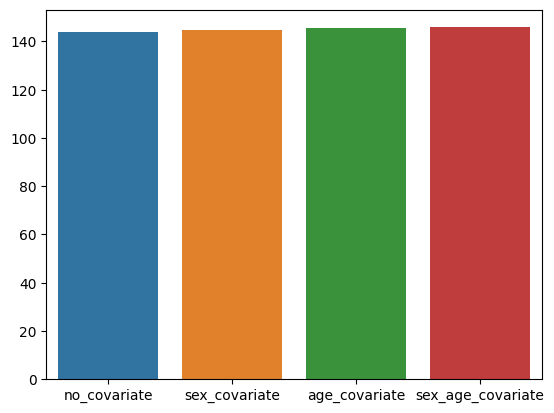

In [72]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic)
print(bic) ##in this case, no covariate is best

In [73]:
#Hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: arousing_1
No. Observations: 28      Method:             ML        
No. Groups:       14      Scale:              6.1787    
Min. group size:  2       Log-Likelihood:     -65.2257  
Max. group size:  2       Converged:          No        
Mean group size:  2.0                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      4.702    3.714  1.266 0.205 -2.577 11.981
trial_type    -0.467    1.547 -0.302 0.763 -3.500  2.566
Vid Var        0.000                                    
========================================================

"""

Model G: disgusting_1 ~ trial_type

In [74]:
##Model G
formula = 'disgusting_1 ~ trial_type'
model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model  vid_randint   randslope  vid_randint_randslope
0   260.338092   130.738574  262.947405             316.356895


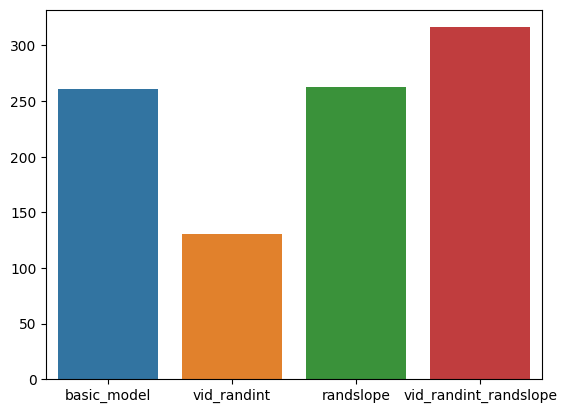

In [75]:
#test random effects
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##in this case, vidrandint is best

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0    130.738574     134.063467     133.637643         136.889325


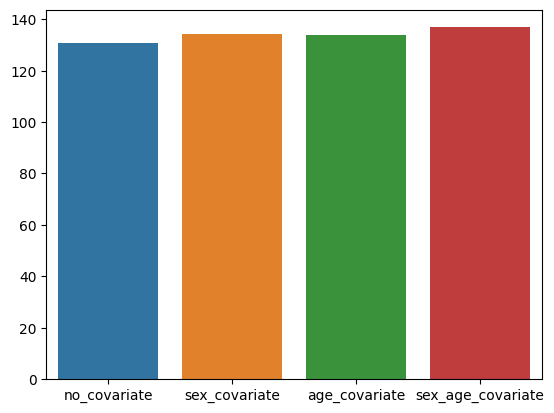

In [76]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic)
print(bic) ##in this case, no covariate is best

In [77]:
#Hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: disgusting_1
No. Observations: 28      Method:             ML          
No. Groups:       14      Scale:              3.8018      
Min. group size:  2       Log-Likelihood:     -58.7049    
Max. group size:  2       Converged:          Yes         
Mean group size:  2.0                                     
-----------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     1.523     1.192  1.278  0.201  -0.813   3.860
trial_type    1.916     0.747  2.563  0.010   0.451   3.381
Vid Var       0.000     0.000                              
==========================================================

"""

Model H: frightening_1 ~ trial_type

In [78]:
#Model H
formula = 'frightening_1 ~ trial_type'
model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

   basic_model  vid_randint   randslope  vid_randint_randslope
0   263.867722   143.129071  263.829003             315.208403


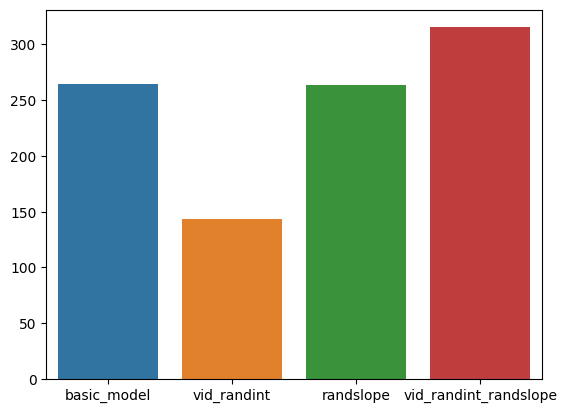

In [79]:
#test random effects
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##in this case, vidrandint is best

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0    143.129071     373.437413     147.488593         171.338338


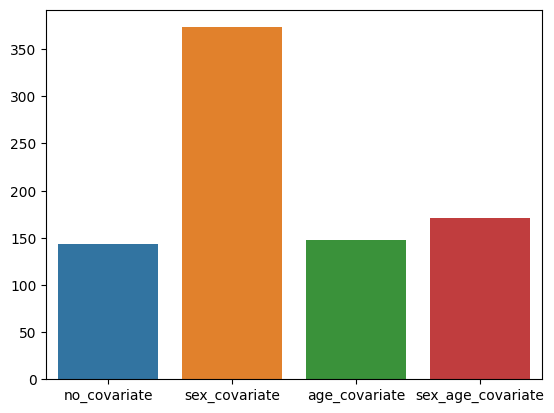

In [80]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic)
print(bic) ##in this case, no covariate is best

In [81]:
#Hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: frightening_1
No. Observations: 28      Method:             ML           
No. Groups:       14      Scale:              6.0366       
Min. group size:  2       Log-Likelihood:     -64.9001     
Max. group size:  2       Converged:          Yes          
Mean group size:  2.0                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     7.857     3.789   2.074  0.038   0.431  15.283
trial_type   -1.979     1.579  -1.253  0.210  -5.073   1.116
Vid Var       0.000                                         
===========================================================

"""

<b>Interpretation of these models:</b>
<li>Expect points to differ from fear vs disgust in all 4 models (i.e.. an effect of feedback type in models E-H)

Text(258.7682291666667, 0.5, 'Fear')

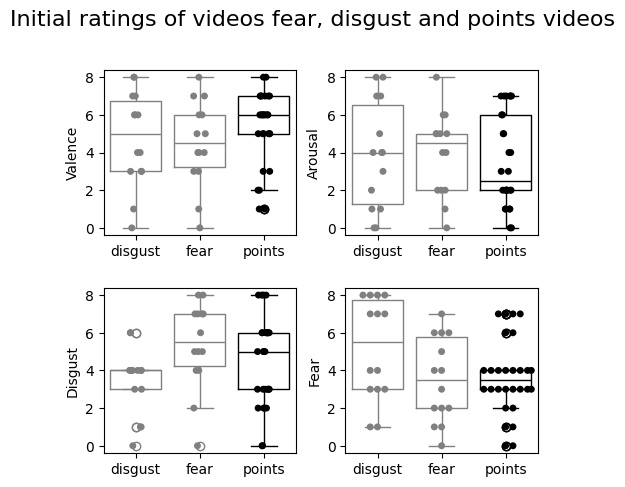

In [58]:
#example plot for this data
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1']].sort_values('trial_type')
fig, axes = plt.subplots(2,2)
title="Initial ratings of videos fear, disgust and points videos"
plt.suptitle(title, fontsize=16)
fig.tight_layout(pad=1.5)
fig.set_size_inches(5, 5)

order=['fear', 'disgust', 'points']
palette = {'fear': '0.5',
            'disgust': '0.5',
            'points': '0'}
sns.boxplot(data=data, ax=axes[0,0],   x='trial_type', hue='trial_type', y='unpleasant_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.stripplot(data=data, ax=axes[0,0],  x='trial_type', hue='trial_type', y='unpleasant_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Valence')

sns.boxplot(data=data, ax=axes[0,1], x='trial_type', hue='trial_type', y='arousing_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.stripplot(data=data, ax=axes[0,1], x='trial_type', hue='trial_type', y='arousing_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Arousal')

sns.boxplot(data=data, ax=axes[1,0], x='trial_type', hue='trial_type', y='disgusting_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.stripplot(data=data, ax=axes[1,0], x='trial_type', hue='trial_type', y='disgusting_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Disgust')

sns.boxplot(data=data, ax=axes[1,1], x='trial_type',  hue='trial_type', y='frightening_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.swarmplot(data=data, ax=axes[1,1], x='trial_type',  hue='trial_type',  y='frightening_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('Fear')